In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE

In [5]:
def dtype_compressor(df):
  #object 
  # when unique ratio > 0.5, catogory stands less memory than object
  converted_obj = pd.DataFrame()
  df_obj = df.select_dtypes(include=['object'])
  for col in df_obj.columns:
    converted_obj.loc[:,col] = df_obj.loc[:,col].astype('category')

  # numbers
  df_down_num = pd.DataFrame()
  df_num = df.select_dtypes(include=['number'])
  for col in df_num.columns:
    df_down_num.loc[:,col] = pd.to_numeric(df_num.loc[:,col],downcast='signed')

  # merge
  df = pd.concat([converted_obj,df_down_num],axis=1)
  
  del converted_obj, df_obj, df_down_num, df_num  
  
  return df

In [6]:
def fast_datetime(s):
    dates = {date:pd.to_datetime(date,format='%Y-%m-%d') for date in s.unique()}
    return s.map(dates)

In [7]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

---

### 讀取並觀察資料

In [8]:
KKboxTrainMembersTransac = pd.read_csv('KKboxTrainMembersTransac.csv')

In [9]:
KKboxTrainMembersTransac.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,last_last_churn,last_auto_renew,is_discount,amount_per_day,longtime_user
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18,36,0,9,2005-04-06,1,0,2,2.48,0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38,1,9,2005-04-07,0,1,23,4.99,1
2,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38,1,9,2005-04-07,0,1,23,4.99,1
3,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11,27,0,9,2005-10-16,0,1,10,4.97,0
4,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13,23,0,9,2005-11-02,1,0,3,3.11,0


In [10]:
KKboxTrainMembersTransac = dtype_compressor(KKboxTrainMembersTransac)

In [11]:
d = ['registration_init_time']
for col in d:
  KKboxTrainMembersTransac[col] = fast_datetime(KKboxTrainMembersTransac[col])

In [12]:
# 針對名目特徵(無序類別)做one-hot encoding，並減少一維度作為減少特徵間高相關性處理
ToDummiesCol = ['city', 'gender', 'registered_via', 'last_last_churn',\
                 'last_auto_renew', 'longtime_user']
KKboxTrainMembersTransac = pd.get_dummies(KKboxTrainMembersTransac, prefix_sep="__", columns=ToDummiesCol, drop_first=True)

In [13]:
KKboxTrainMembersTransac.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767924 entries, 0 to 767923
Data columns (total 35 columns):
msno                      767924 non-null category
registration_init_time    767924 non-null datetime64[ns]
is_churn                  767924 non-null int8
bd                        767924 non-null int8
is_discount               767924 non-null int16
amount_per_day            767924 non-null float64
city__3                   767924 non-null uint8
city__4                   767924 non-null uint8
city__5                   767924 non-null uint8
city__6                   767924 non-null uint8
city__7                   767924 non-null uint8
city__8                   767924 non-null uint8
city__9                   767924 non-null uint8
city__10                  767924 non-null uint8
city__11                  767924 non-null uint8
city__12                  767924 non-null uint8
city__13                  767924 non-null uint8
city__14                  767924 non-null uint8
city__15     

In [14]:
KKboxTrainMembersTransac.describe()

,is_churn,bd,is_discount,amount_per_day,city__3,city__4,city__5,city__6,city__7,city__8,...,city__22,gender__0,gender__1,registered_via__4,registered_via__7,registered_via__9,registered_via__13,last_last_churn__1,last_auto_renew__1,longtime_user__1
count,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,...,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00,767924.00
mean,0.10,29.96,18.68,4.81,0.01,0.11,0.16,0.06,0.01,0.02,...,0.10,0.46,0.52,0.07,0.19,0.52,0.00,0.01,0.78,0.44
std,0.30,8.89,8.38,0.59,0.11,0.31,0.37,0.24,0.08,0.13,...,0.30,0.50,0.50,0.25,0.39,0.50,0.03,0.10,0.41,0.50
min,0.00,13.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,24.00,12.00,4.77,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
50%,0.00,28.00,21.00,4.94,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
75%,0.00,34.00,26.00,4.97,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00
max,1.00,99.00,244.00,7.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


---

##### 拆分訓練集與測試集

In [54]:
X = KKboxTrainMembersTransac.iloc[:,3:]
y = KKboxTrainMembersTransac.iloc[:,2]

In [55]:
# from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=87)

---

##### XGBoost提供了一個優化存取與運算速度的DMatrix

In [56]:
dtrain=xgb.DMatrix(X_train, label=y_train)
dtest=xgb.DMatrix(X_test)

C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


* max_depth： 树的最大深度。缺省值为6，取值范围为：[1,∞]
* eta：为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。 eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3，取值范围为：[0,1]
* silent：取0时表示打印出运行时信息，取1时表示以缄默方式运行，不打印运行时信息。缺省值为0
* objective： 定义学习任务及相应的学习目标，“binary:logistic” 表示二分类的逻辑回归问题，输出为概率。
* 其他参数取默认值。

In [118]:
param = {'max_depth':3, 'eta':1, 'silent':0, 'objective':'binary:logistic' }

In [119]:
# 設定boosting迭代計算次數
num_round = 2
import time
starttime = time.clock()

# 訓練模型
bst = xgb.train(param, dtrain, num_round) #  dtrain是训练数据集
 
endtime = time.clock()
print (endtime - starttime)

1.8003322315835248


In [120]:
# Train Accuracy
y_pred_train = bst.predict(dtrain)
# 將概率值轉成二元分類(>=0.5判別成1;<0.5判別成0)
y_prediction_train = [round(value) for value in y_pred_train]
y_train = dtrain.get_label() # 值為輸入數據的第一行
train_accuracy = metrics.accuracy_score(y_train, y_prediction_train)
print ("Train Accuracy: %.2f%%" % (train_accuracy * 100.0))

Train Accuracy: 91.54%


##### XGBoost預測出的結果為概率，但此資料集為二元分類問題(流失/非流失)，所以須將概率值轉換成0或1

In [121]:
# Test Accuracy
y_pred_test = bst.predict(dtest)
# 將概率值轉成二元分類(>=0.5判別成1;<0.5判別成0)
y_prediction_test = [round(value) for value in y_pred_test] # 將概率值轉成二元分類
test_accuracy = metrics.accuracy_score(y_test, y_prediction_test)
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Test Accuracy: 91.52%


AUC: 0.811
Accuracy: 0.915
Precision: 0.697
Recall: 0.305
F1_score: 0.424
              precision    recall  f1-score   support

           0       0.93      0.98      0.95    206774
           1       0.70      0.30      0.42     23604

   micro avg       0.92      0.92      0.92    230378
   macro avg       0.81      0.64      0.69    230378
weighted avg       0.90      0.92      0.90    230378



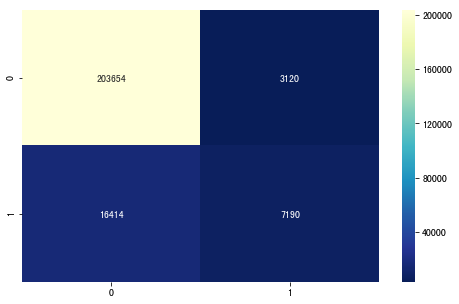

In [122]:
# 驗證
# AUC
auc_bst = roc_auc_score(y_test,y_pred_test)
print('AUC: %.3f' % auc_bst)
# Accuracy
accuracy_bst = metrics.accuracy_score(y_test,y_prediction_test)
print('Accuracy: %.3f' % accuracy_bst)
# Precision
precision_bst = metrics.precision_score(y_test,y_prediction_test)
print('Precision: %.3f' % precision_bst)
# Recall
recall_bst = metrics.recall_score(y_test,y_prediction_test)
print('Recall: %.3f' % recall_bst)
# f1_score
f1_score_bst = metrics.f1_score(y_test,y_prediction_test)
print('F1_score: %.3f' % f1_score_bst)

print(metrics.classification_report(y_test, y_prediction_test))
cm = metrics.confusion_matrix(y_test, y_prediction_test)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt="d")
plt.show()

In [123]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
fpr_binary, tpr_binary, thresholds = roc_curve(y_test, y_prediction_test)

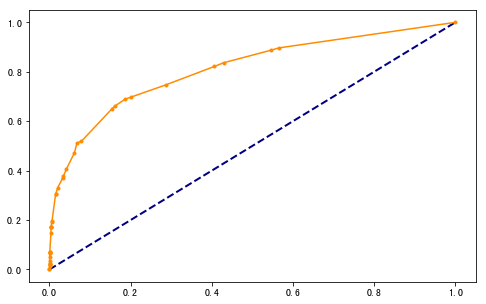

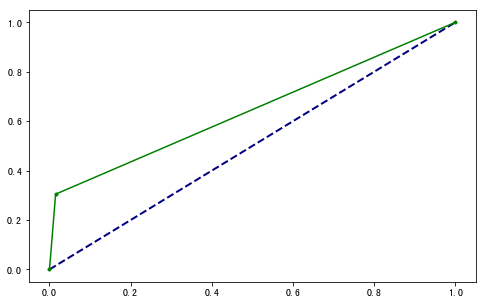

In [124]:
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr, tpr, color='darkorange', marker='.')
plt.show()

lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr_binary, tpr_binary, color='green', marker='.')
plt.show()

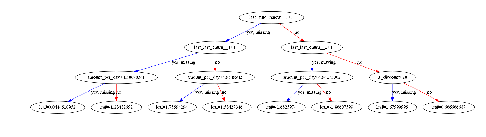

In [125]:
# 可視化
from matplotlib import pyplot
import graphviz

xgb.plot_tree(bst, num_trees=0)
pyplot.show()